<a href="https://colab.research.google.com/github/celsia98/COVID_ML/blob/main/Covid_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import auth
from pyspark.sql import SparkSession
from google.cloud import bigquery
from pyspark.sql import DataFrame
from pyspark.sql.functions import col, year, month, when, split, split
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Authenticate to access Google Cloud
import google.auth
from google.auth import impersonated_credentials
from google.oauth2 import service_account

# Set your Google Cloud credentials for BigQuery
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "/content/learning-analytics-438704-2d0098d5bd4c.json"

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("COVID-19 Data Analysis") \
    .config("spark.jars.packages", "com.google.cloud.spark:spark-bigquery-with-dependencies_2.12:0.29.0") \
    .getOrCreate()

# Define project, dataset, and table for BigQuery
project_id = "bigquery-public-data"
dataset_id = "covid19_open_data_eu"
table_id = "covid19_open_data"

# Load data from BigQuery table
required_columns = [
    "date",
    "location_key",
    "country_code",
    "new_confirmed",
    "new_deceased",
    "cumulative_vaccine_doses_administered_pfizer",
    "cumulative_vaccine_doses_administered_moderna",
    "cumulative_vaccine_doses_administered_janssen",
    "new_vaccine_doses_administered_pfizer",
    "new_vaccine_doses_administered_moderna",
    "new_vaccine_doses_administered_janssen"
]
query = f"""
  SELECT {', '.join(required_columns)}
  FROM `{project_id}.{dataset_id}.{table_id}`
  WHERE country_code IS NOT NULL
  LIMIT 1000000
"""

# Read the data using BigQuery
bq_client = bigquery.Client()
query_job = bq_client.query(query)
rows = query_job.result()

# Convert rows to Pandas DataFrame
pandas_df = rows.to_dataframe()

# Verify the columns in the Pandas DataFrame
#print("Columns in Pandas DataFrame:", pandas_df.columns)

# Convert Pandas DataFrame to PySpark DataFrame
spark_df: DataFrame = spark.createDataFrame(pandas_df)

# Check the years present in the data
year_df = spark_df.withColumn("year", year(col("date")))
#year_df.select("year").distinct().show()

# Show the first few rows of the PySpark DataFrame
#spark_df.show()

# Extract year and country information
spark_df = spark_df.withColumn("year", year(col("date")))

# Convert to Pandas DataFrame for visualization
pandas_df = spark_df.toPandas()

# Ensure that 'year' column is of type int for plotting
pandas_df['year'] = pandas_df['year'].astype(int)

print(pandas_df.head(20))

          date location_key country_code  new_confirmed  new_deceased  \
0   2022-08-11           AD           AD            0.0           0.0   
1   2020-10-04           AD           AD          260.0           0.0   
2   2021-03-22           AD           AD           46.0           0.0   
3   2021-05-03           AD           AD           21.0           0.0   
4   2022-05-12           AD           AD            0.0           0.0   
5   2021-12-31           AD           AD            0.0           0.0   
6   2021-11-09           AE           AE           75.0           0.0   
7   2021-06-29           AE           AE         1747.0           4.0   
8   2022-01-21           AE           AE         3020.0           4.0   
9   2022-01-26           AE           AE         2638.0           4.0   
10  2020-03-13           AE           AE           13.0           0.0   
11  2021-11-11           AE           AE           72.0           0.0   
12  2020-08-05           AE           AE          2

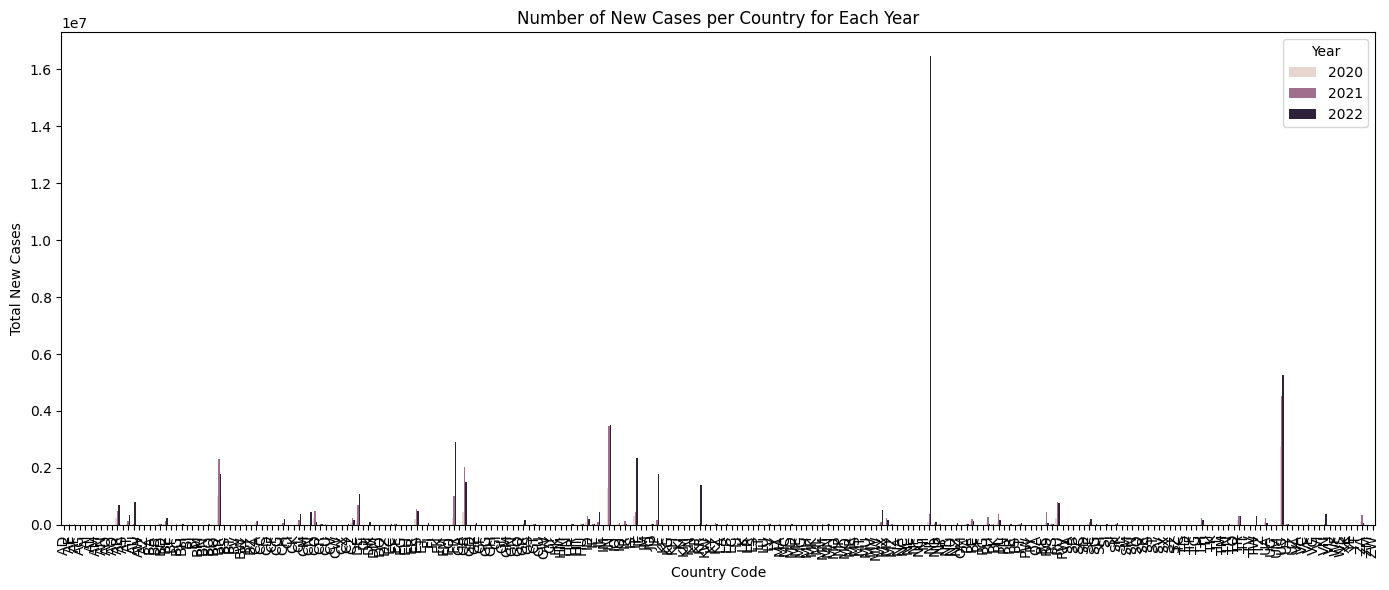

In [ ]:
# Plot 1: Number of new cases per each country for each year
plt.figure(figsize=(14, 6))
pandas_grouped_df = pandas_df.groupby(['country_code', 'year']).agg({'new_confirmed': 'sum'}).reset_index()
sns.barplot(data=pandas_grouped_df, x='country_code', y='new_confirmed', hue='year', errorbar=None)
plt.title('Number of New Cases per Country for Each Year')
plt.xlabel('Country Code')
plt.ylabel('Total New Cases')
plt.xticks(rotation=90)
plt.legend(title='Year')
plt.tight_layout()
plt.show()


<ipython-input-6-681af9110025>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_2020, x='country_code', y='new_confirmed', palette='viridis')


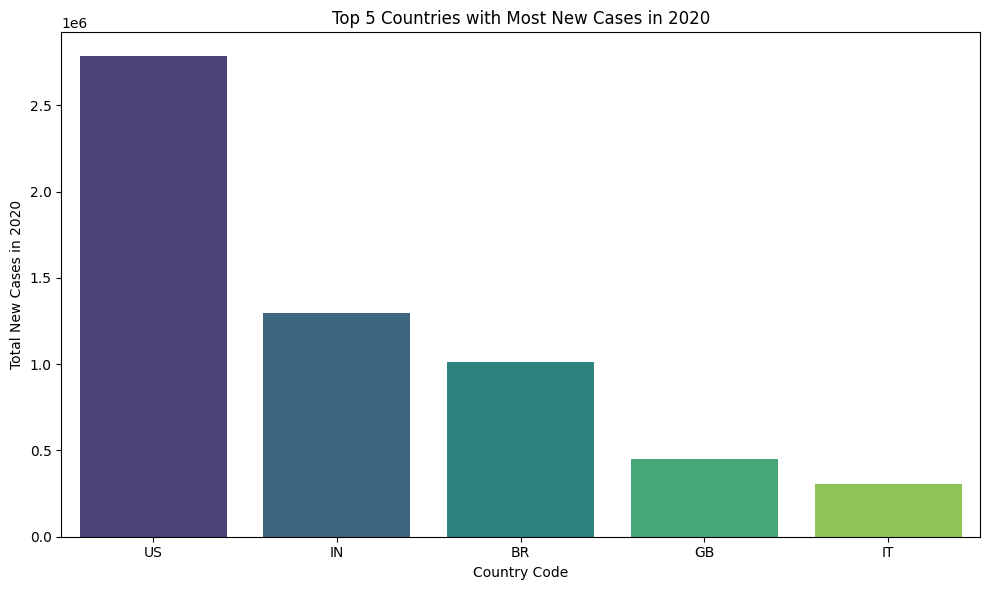

In [ ]:
# Plot 1.1: Top 5 countries with most cases in 2020
if 'new_confirmed' in pandas_grouped_df.columns:
    top_5_2020 = pandas_grouped_df[pandas_grouped_df['year'] == 2020].nlargest(5, 'new_confirmed')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_5_2020, x='country_code', y='new_confirmed', palette='viridis')
    plt.title('Top 5 Countries with Most New Cases in 2020')
    plt.xlabel('Country Code')
    plt.ylabel('Total New Cases in 2020')
    plt.tight_layout()
    plt.show()


<ipython-input-7-f6e1064e690f>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_2021, x='country_code', y='new_confirmed', palette='viridis')


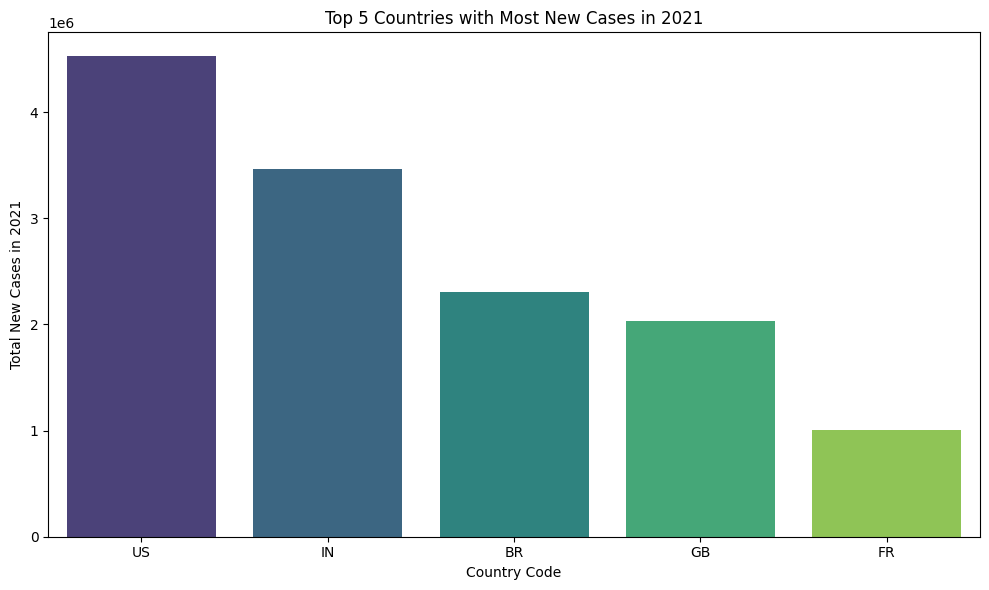

In [ ]:
# Plot 1.2: Top 5 countries with most cases in 2021
if 'new_confirmed' in pandas_grouped_df.columns:
    top_5_2021 = pandas_grouped_df[pandas_grouped_df['year'] == 2021].nlargest(5, 'new_confirmed')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_5_2021, x='country_code', y='new_confirmed', palette='viridis')
    plt.title('Top 5 Countries with Most New Cases in 2021')
    plt.xlabel('Country Code')
    plt.ylabel('Total New Cases in 2021')
    plt.tight_layout()
    plt.show()

<ipython-input-8-b8e0570e431d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_2022, x='country_code', y='new_confirmed', palette='viridis')


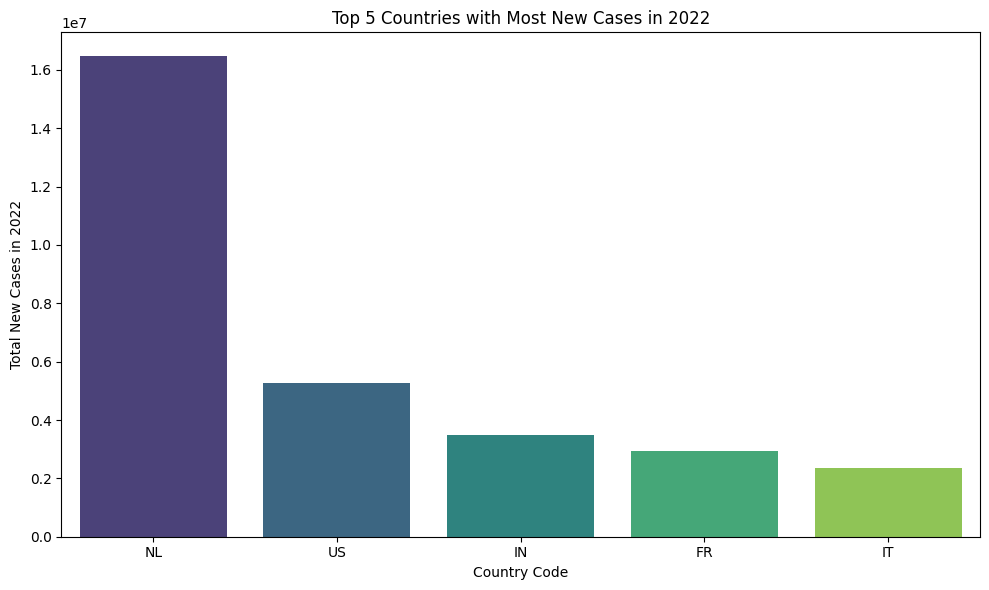

In [ ]:
# Plot 1.3: Top 5 countries with most cases in 2022
if 'new_confirmed' in pandas_grouped_df.columns:
    top_5_2022 = pandas_grouped_df[pandas_grouped_df['year'] == 2022].nlargest(5, 'new_confirmed')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_5_2022, x='country_code', y='new_confirmed', palette='viridis')
    plt.title('Top 5 Countries with Most New Cases in 2022')
    plt.xlabel('Country Code')
    plt.ylabel('Total New Cases in 2022')
    plt.tight_layout()
    plt.show()

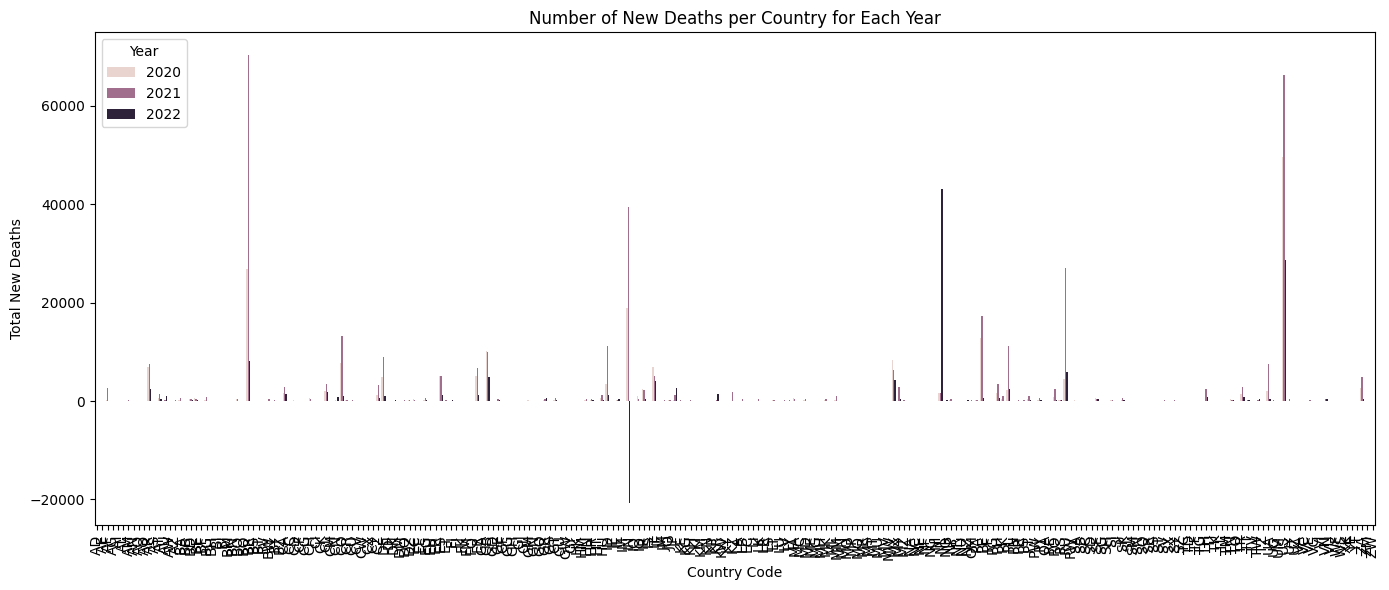

In [ ]:
# Plot 2: Number of new deaths per each country for each year
plt.figure(figsize=(14, 6))
pandas_grouped_df = pandas_df.groupby(['country_code', 'year']).agg({'new_deceased': 'sum'}).reset_index()
sns.barplot(data=pandas_grouped_df, x='country_code', y='new_deceased', hue='year', errorbar=None)
plt.title('Number of New Deaths per Country for Each Year')
plt.xlabel('Country Code')
plt.ylabel('Total New Deaths')
plt.xticks(rotation=90)
plt.legend(title='Year')
plt.tight_layout()
plt.show()


<ipython-input-10-040d9cc8d48a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_2020, x='country_code', y='new_deceased', palette='viridis')


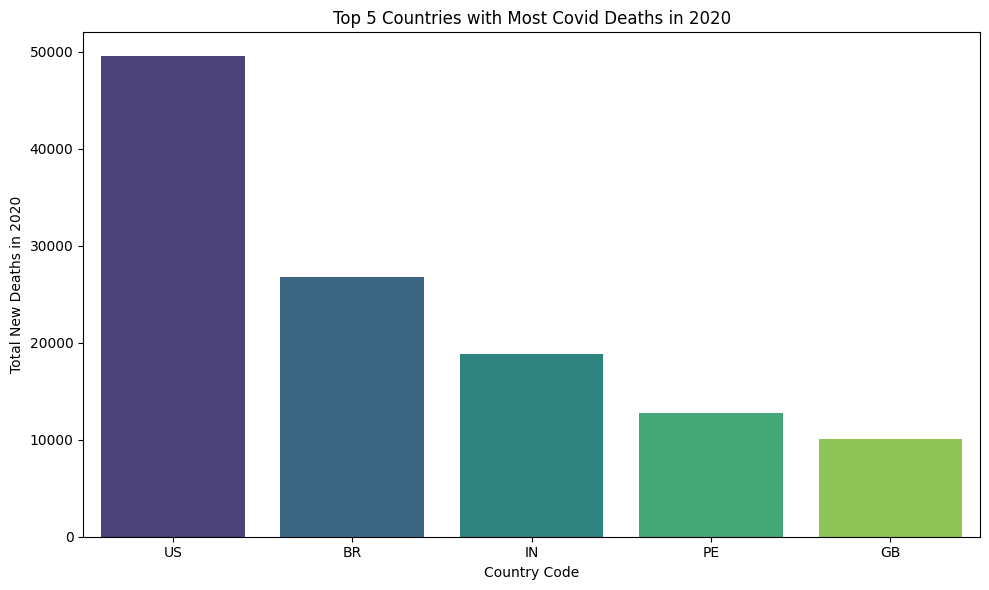

In [ ]:
# Plot 2.1: Top 5 countries with most cases in 2020
if 'new_deceased' in pandas_grouped_df.columns:
    top_5_2020 = pandas_grouped_df[pandas_grouped_df['year'] == 2020].nlargest(5, 'new_deceased')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_5_2020, x='country_code', y='new_deceased', palette='viridis')
    plt.title('Top 5 Countries with Most Covid Deaths in 2020')
    plt.xlabel('Country Code')
    plt.ylabel('Total New Deaths in 2020')
    plt.tight_layout()
    plt.show()


<ipython-input-11-2c187a0642fa>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_2021, x='country_code', y='new_deceased', palette='viridis')


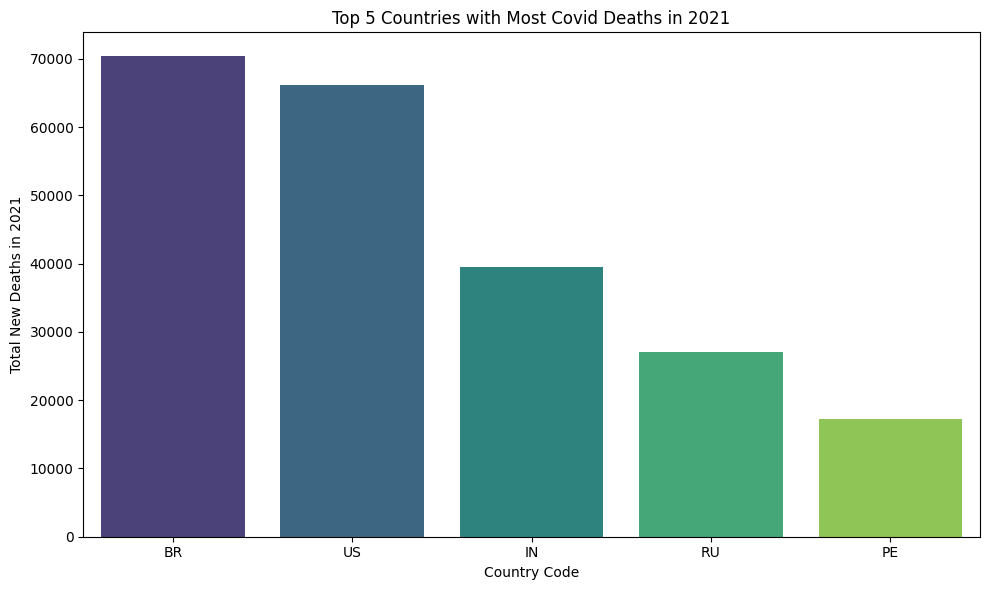

In [ ]:
# Plot 2.2: Top 5 countries with most cases in 2021
if 'new_deceased' in pandas_grouped_df.columns:
    top_5_2021 = pandas_grouped_df[pandas_grouped_df['year'] == 2021].nlargest(5, 'new_deceased')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_5_2021, x='country_code', y='new_deceased', palette='viridis')
    plt.title('Top 5 Countries with Most Covid Deaths in 2021')
    plt.xlabel('Country Code')
    plt.ylabel('Total New Deaths in 2021')
    plt.tight_layout()
    plt.show()


<ipython-input-12-05548b53ac2e>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_5_2022, x='country_code', y='new_deceased', palette='viridis')


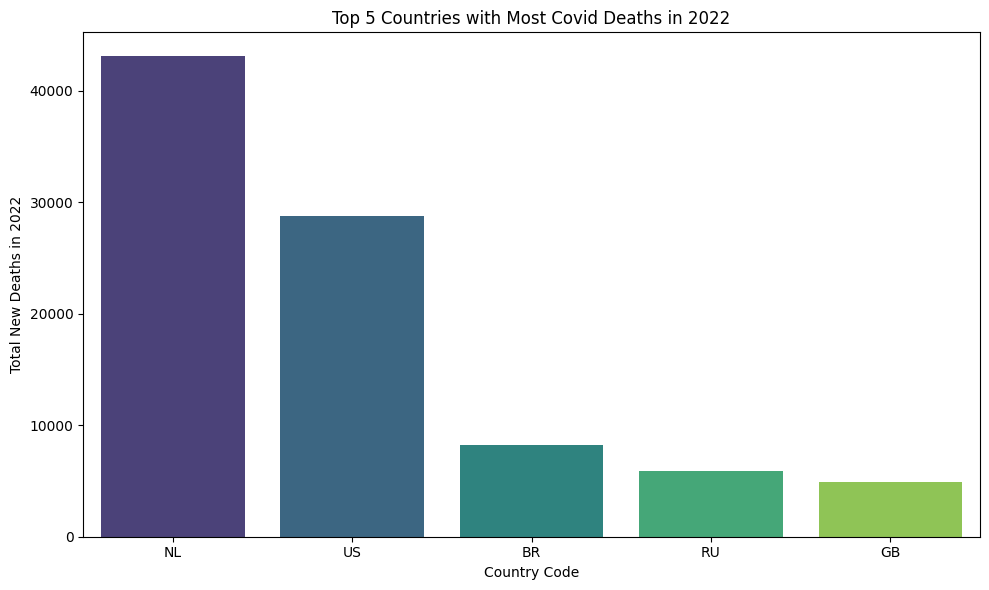

In [ ]:
# Plot 2.3: Top 5 countries with most cases in 2022
if 'new_deceased' in pandas_grouped_df.columns:
    top_5_2022 = pandas_grouped_df[pandas_grouped_df['year'] == 2022].nlargest(5, 'new_deceased')
    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_5_2022, x='country_code', y='new_deceased', palette='viridis')
    plt.title('Top 5 Countries with Most Covid Deaths in 2022')
    plt.xlabel('Country Code')
    plt.ylabel('Total New Deaths in 2022')
    plt.tight_layout()
    plt.show()

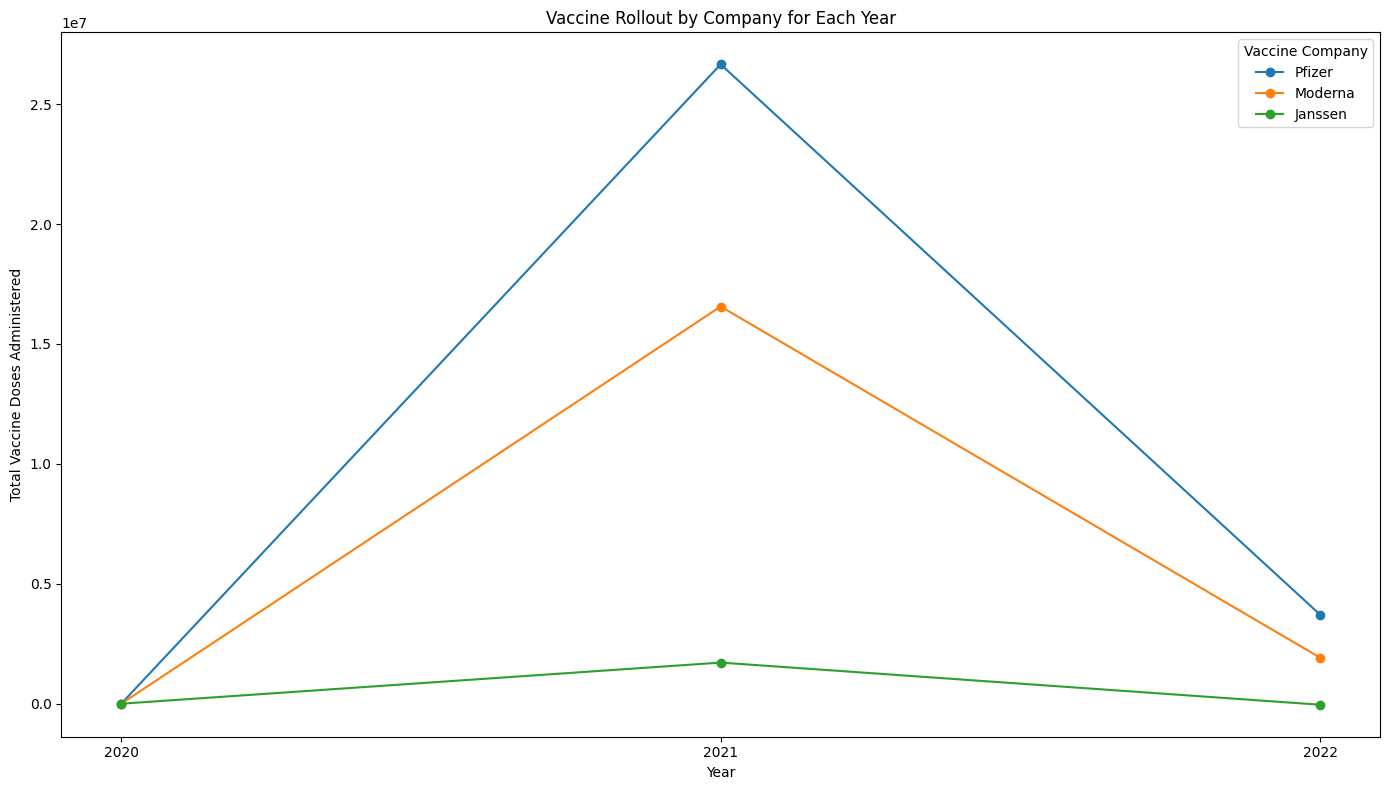

In [ ]:
#Line Plot: Vaccine Rollout by Company for Each Year
plt.figure(figsize=(14, 8))
rollout_grouped_df = pandas_df.groupby(['year']).agg({
    'new_vaccine_doses_administered_pfizer': 'sum',
    'new_vaccine_doses_administered_moderna': 'sum',
    'new_vaccine_doses_administered_janssen': 'sum'
}).reset_index()

plt.plot(rollout_grouped_df['year'].astype(int), rollout_grouped_df['new_vaccine_doses_administered_pfizer'], marker='o', label='Pfizer')
plt.xticks(ticks=rollout_grouped_df['year'].astype(int), labels=[2020, 2021, 2022])
plt.plot(rollout_grouped_df['year'].astype(int), rollout_grouped_df['new_vaccine_doses_administered_moderna'], marker='o', label='Moderna')
plt.plot(rollout_grouped_df['year'].astype(int), rollout_grouped_df['new_vaccine_doses_administered_janssen'], marker='o', label='Janssen')

plt.title('Vaccine Rollout by Company for Each Year')
plt.xlabel('Year')
plt.ylabel('Total Vaccine Doses Administered')
plt.legend(title='Vaccine Company')
plt.tight_layout()
plt.show()


In [ ]:
# Load data from BigQuery table
required_columns = [
    "date",
    "location_key",
    "country_code",
    "new_confirmed",
    "new_deceased",
    "cumulative_vaccine_doses_administered_pfizer",
    "cumulative_vaccine_doses_administered_moderna",
    "cumulative_vaccine_doses_administered_janssen",
    "new_vaccine_doses_administered_pfizer",
    "new_vaccine_doses_administered_moderna",
    "new_vaccine_doses_administered_janssen"
]
query = f"""
  SELECT {', '.join(required_columns)}
  FROM `{project_id}.{dataset_id}.{table_id}`
  WHERE country_code = 'US' AND (
    new_vaccine_doses_administered_pfizer IS NOT NULL OR
    new_vaccine_doses_administered_moderna IS NOT NULL OR
    new_vaccine_doses_administered_janssen IS NOT NULL OR
    cumulative_vaccine_doses_administered_pfizer IS NOT NULL OR
    cumulative_vaccine_doses_administered_moderna IS NOT NULL OR
    cumulative_vaccine_doses_administered_janssen IS NOT NULL
  )
  LIMIT 1000000
"""

# Read the data using BigQuery
bq_client = bigquery.Client()
query_job = bq_client.query(query)
rows = query_job.result()

# Convert rows to Pandas DataFrame
pandas_df = rows.to_dataframe()

# Convert Pandas DataFrame to PySpark DataFrame
spark_df: DataFrame = spark.createDataFrame(pandas_df)

# Extract year, month, and state information
spark_df = spark_df.withColumn("year", year(col("date")))
spark_df = spark_df.withColumn("month", month(col("date")))
spark_df = spark_df.withColumn("state", split(col("location_key"), '_').getItem(1))

# Convert to Pandas DataFrame for visualization
pandas_df = spark_df.toPandas()

# Ensure that 'year' column is of type int for plotting
pandas_df['year'] = pandas_df['year'].astype(int)


<ipython-input-15-5cca353d0538>:15: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


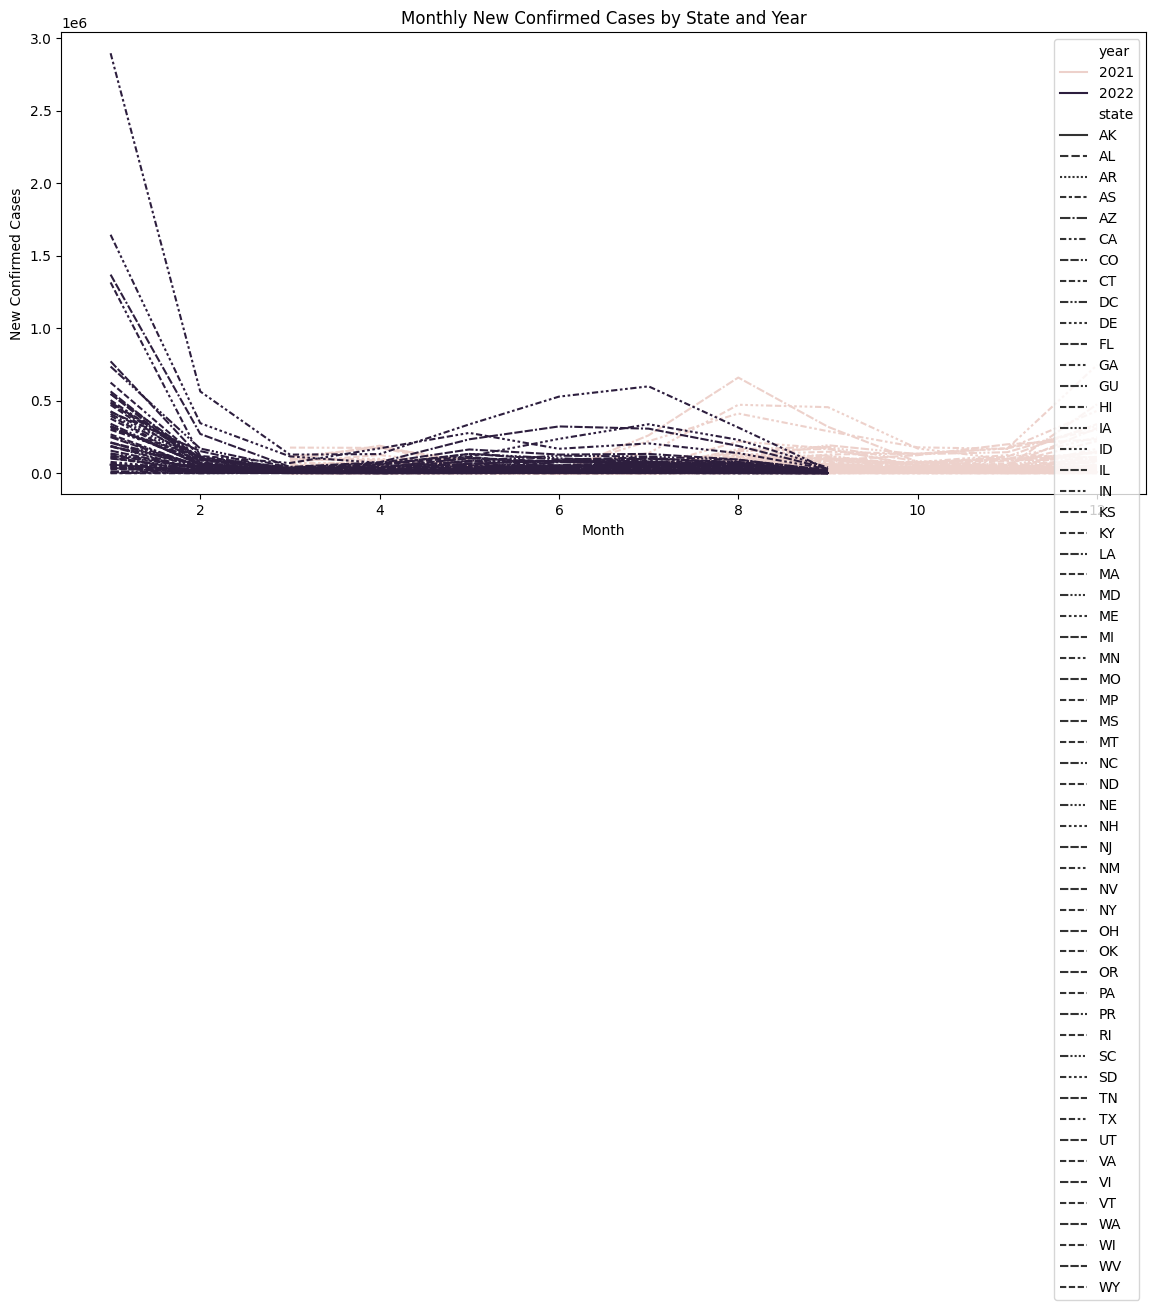

In [ ]:
# Monthly Trends Analysis
monthly_trends_df = pandas_df.groupby(['year', 'month', 'state']).agg({
    'new_confirmed': 'sum',
    'new_deceased': 'sum',
    'new_vaccine_doses_administered_pfizer': 'sum',
    'new_vaccine_doses_administered_moderna': 'sum',
    'new_vaccine_doses_administered_janssen': 'sum'
}).reset_index()

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_trends_df, x='month', y='new_confirmed', hue='year', style='state')
plt.title('Monthly New Confirmed Cases by State and Year')
plt.xlabel('Month')
plt.ylabel('New Confirmed Cases')
plt.tight_layout()
plt.show()


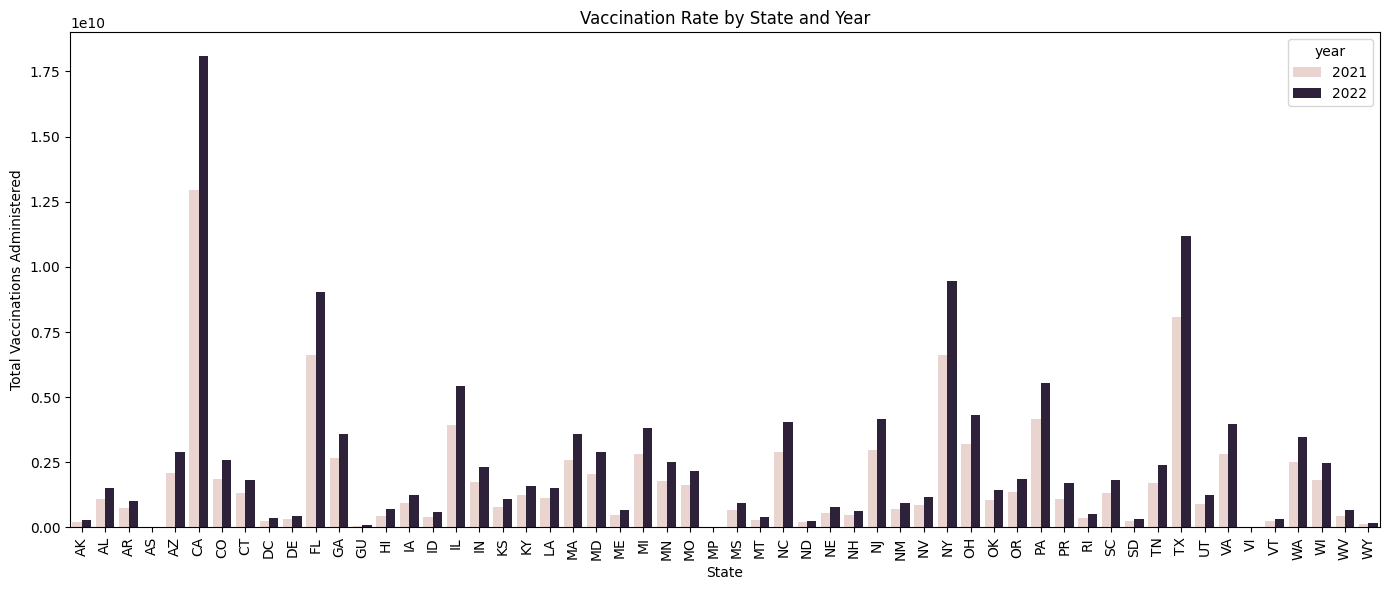

In [ ]:
# Vaccination Rate Analysis
pandas_df['total_vaccinations'] = pandas_df['cumulative_vaccine_doses_administered_pfizer'] + \
                                  pandas_df['cumulative_vaccine_doses_administered_moderna'] + \
                                  pandas_df['cumulative_vaccine_doses_administered_janssen']

vaccination_rate_df = pandas_df.groupby(['state', 'year']).agg({'total_vaccinations': 'sum'}).reset_index()
plt.figure(figsize=(14, 6))
sns.barplot(data=vaccination_rate_df, x='state', y='total_vaccinations', hue='year')
plt.title('Vaccination Rate by State and Year')
plt.xlabel('State')
plt.ylabel('Total Vaccinations Administered')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

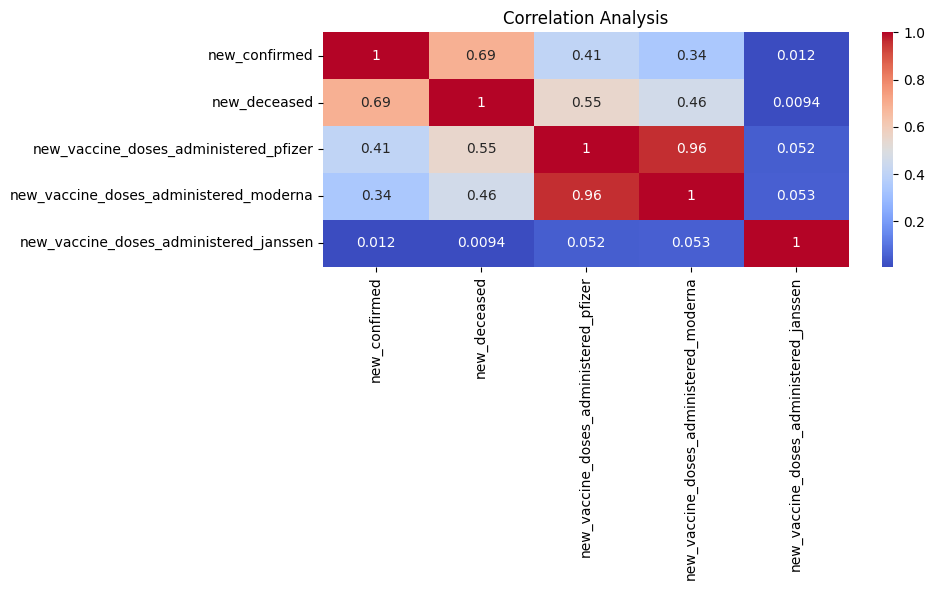

In [ ]:
# Correlation Analysis
correlation_df = pandas_df[['new_confirmed', 'new_deceased', 'new_vaccine_doses_administered_pfizer',
                            'new_vaccine_doses_administered_moderna', 'new_vaccine_doses_administered_janssen']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_df, annot=True, cmap='coolwarm')
plt.title('Correlation Analysis')
plt.tight_layout()
plt.show()

<ipython-input-18-23ff97ea082c>:9: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()
<ipython-input-18-23ff97ea082c>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pandas_df['mortality_rate'] = pandas_df['new_deceased'] / pandas_df['new_confirmed']


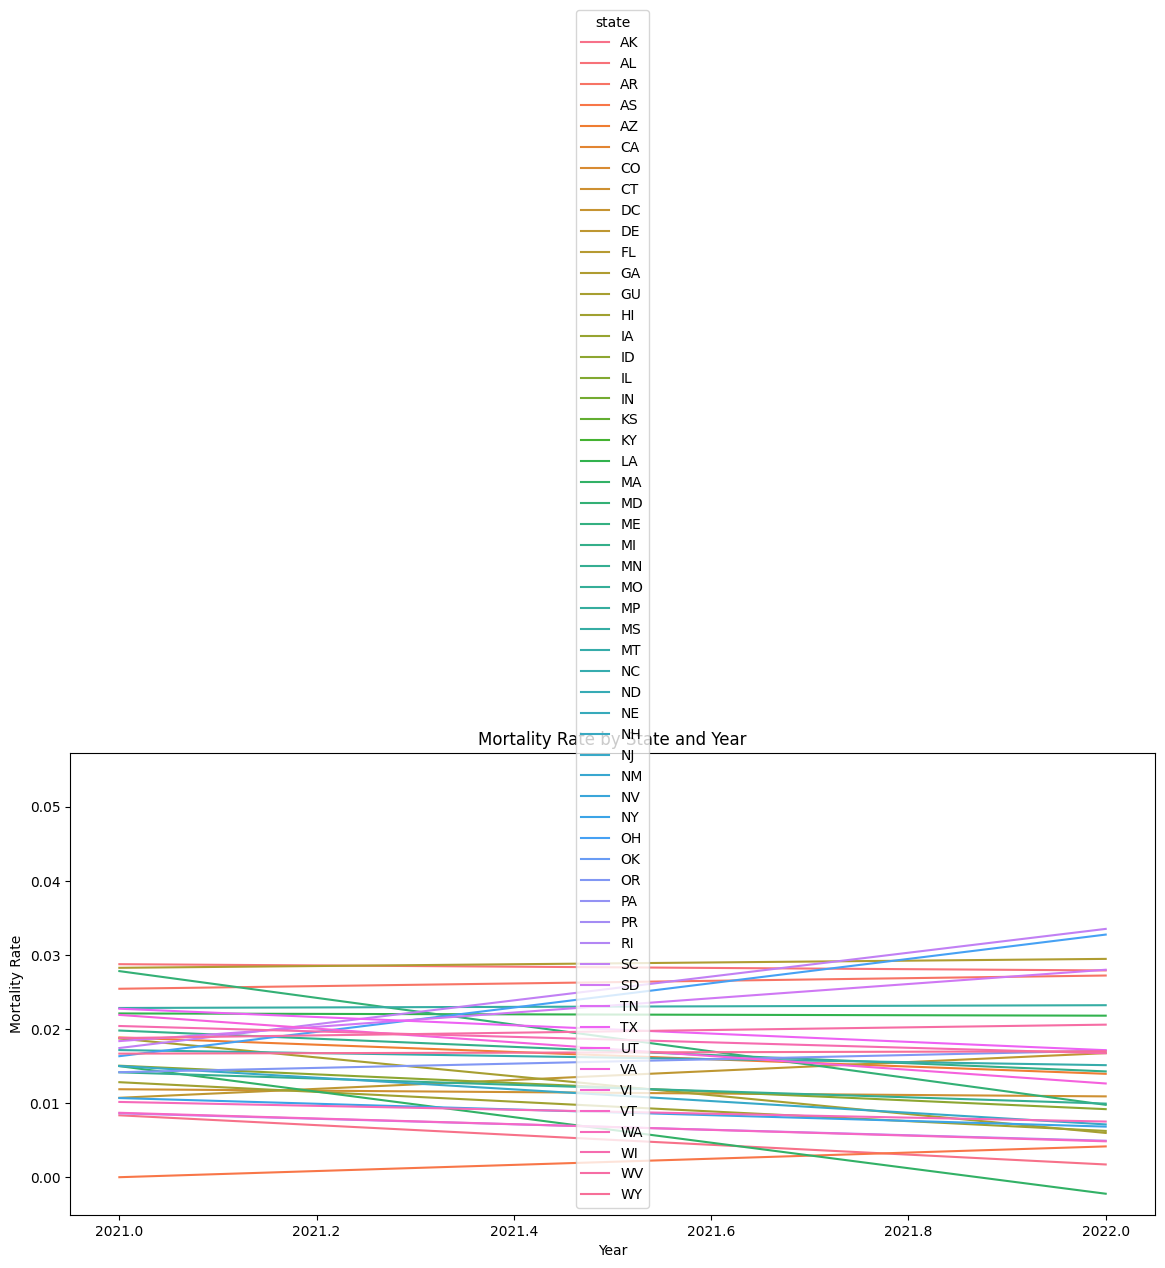

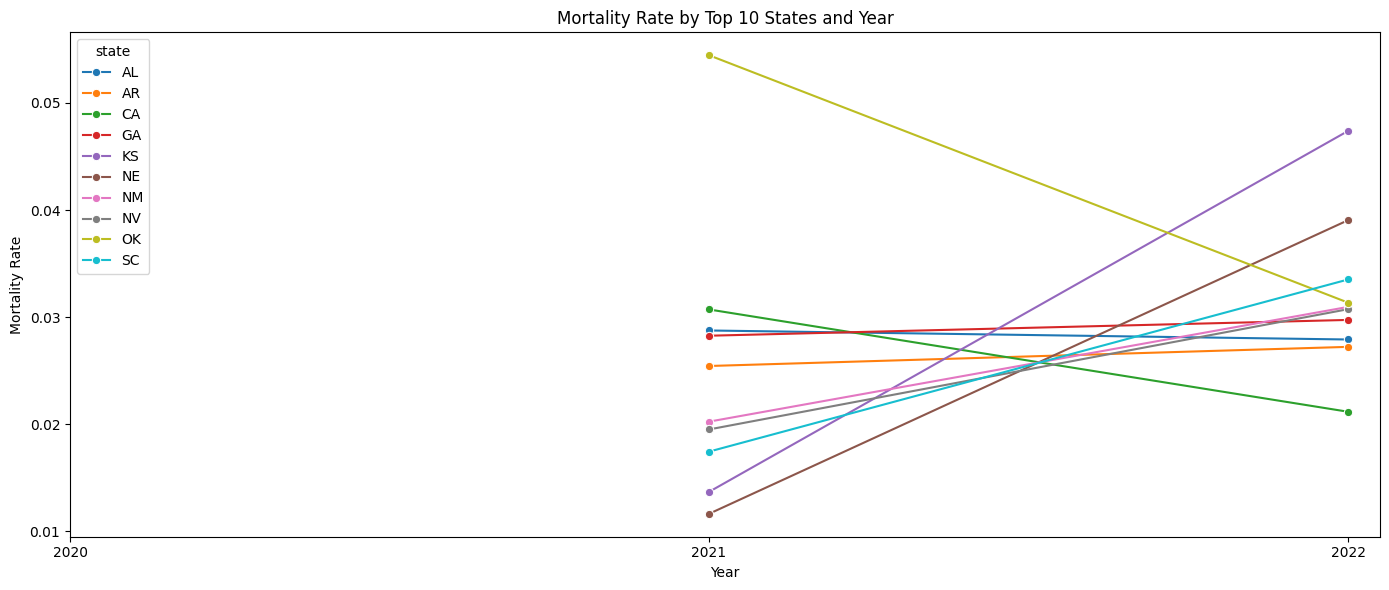

In [ ]:
# Mortality Rate by State
pandas_df['mortality_rate'] = pandas_df['new_deceased'] / pandas_df['new_confirmed']
mortality_rate_df = pandas_df.groupby(['state', 'year']).agg({'mortality_rate': 'mean'}).reset_index()
plt.figure(figsize=(14, 6))
sns.lineplot(data=mortality_rate_df, x='year', y='mortality_rate', hue='state')
plt.title('Mortality Rate by State and Year')
plt.xlabel('Year')
plt.ylabel('Mortality Rate')
plt.tight_layout()

# Filter out rows where new_confirmed is zero to avoid division by zero
pandas_df = pandas_df[pandas_df['new_confirmed'] > 0]

# Recalculate mortality rate
pandas_df['mortality_rate'] = pandas_df['new_deceased'] / pandas_df['new_confirmed']

# Group by state and year, and calculate the mean mortality rate
mortality_rate_df = pandas_df.groupby(['state', 'year']).agg({'mortality_rate': 'mean'}).reset_index()

# Select top 10 states with highest average mortality rate
top_10_states = mortality_rate_df.groupby('state')['mortality_rate'].mean().nlargest(10).index
mortality_rate_df = mortality_rate_df[mortality_rate_df['state'].isin(top_10_states)]

# Plot the mortality rate for the top 10 states
plt.figure(figsize=(14, 6))
sns.lineplot(data=mortality_rate_df, x='year', y='mortality_rate', hue='state', marker='o')
plt.xticks(ticks=[2020, 2021, 2022], labels=[2020, 2021, 2022])
plt.title('Mortality Rate by Top 10 States and Year')
plt.xlabel('Year')
plt.ylabel('Mortality Rate')
plt.tight_layout()
plt.show()


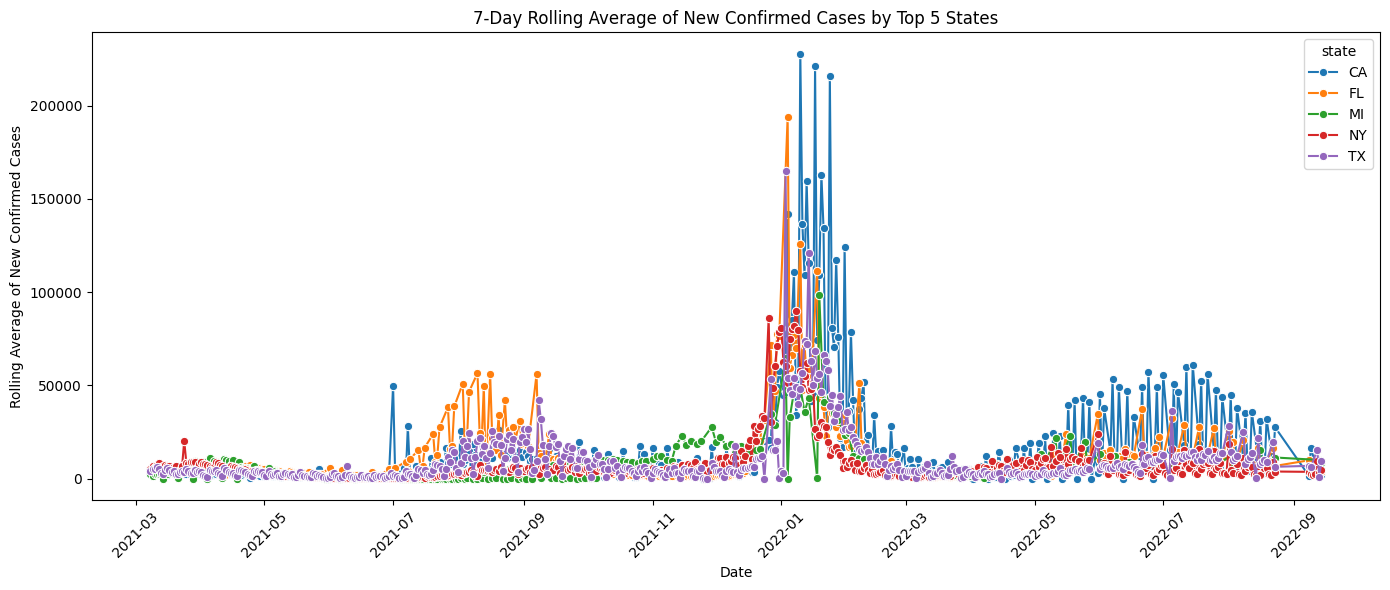

In [ ]:
# Rolling Average Analysis for Top 5 States with markers
# Select top 5 states with the highest average rolling new confirmed cases
top_5_states_rolling_avg = pandas_df.groupby('state')['new_confirmed'].mean().nlargest(5).index
pandas_df_top_5 = pandas_df[pandas_df['state'].isin(top_5_states_rolling_avg)]

plt.figure(figsize=(14, 6))
sns.lineplot(data=pandas_df_top_5, x='date', y='new_confirmed', hue='state', marker='o', palette='tab10')
plt.title('7-Day Rolling Average of New Confirmed Cases by Top 5 States')
plt.xlabel('Date')
plt.ylabel('Rolling Average of New Confirmed Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-20-88346b74d243>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_states_vaccination_df, x='state', y='total_vaccinations', palette='viridis')


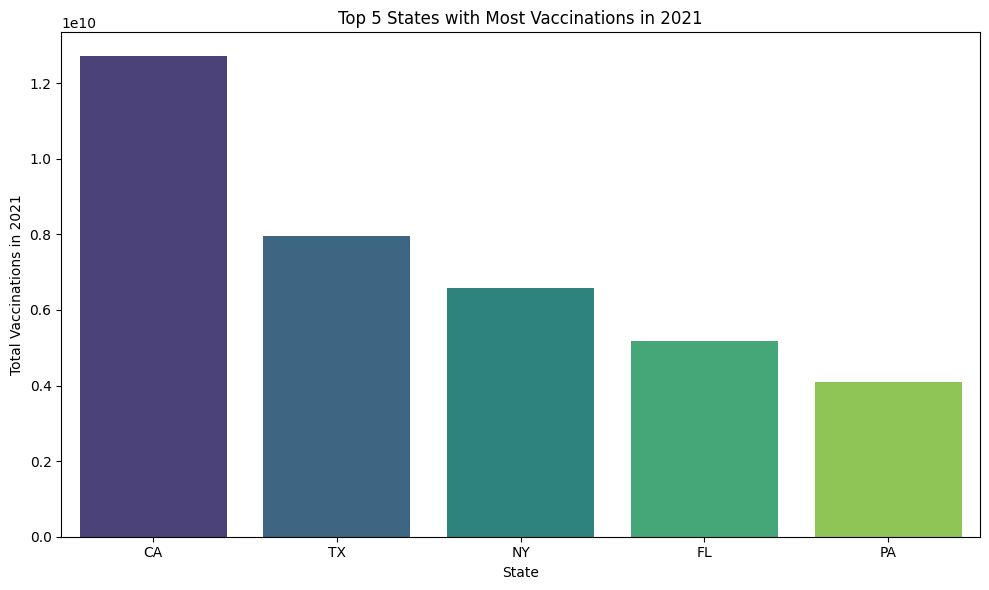

In [ ]:
# Top N States for Vaccinations
top_states_vaccination_df = pandas_df.groupby(['state', 'year']).agg({'total_vaccinations': 'sum'}).reset_index()
top_states_vaccination_df = top_states_vaccination_df[top_states_vaccination_df['year'] == 2021].nlargest(5, 'total_vaccinations')
plt.figure(figsize=(10, 6))
sns.barplot(data=top_states_vaccination_df, x='state', y='total_vaccinations', palette='viridis')
plt.title('Top 5 States with Most Vaccinations in 2021')
plt.xlabel('State')
plt.ylabel('Total Vaccinations in 2021')
plt.tight_layout()
plt.show()

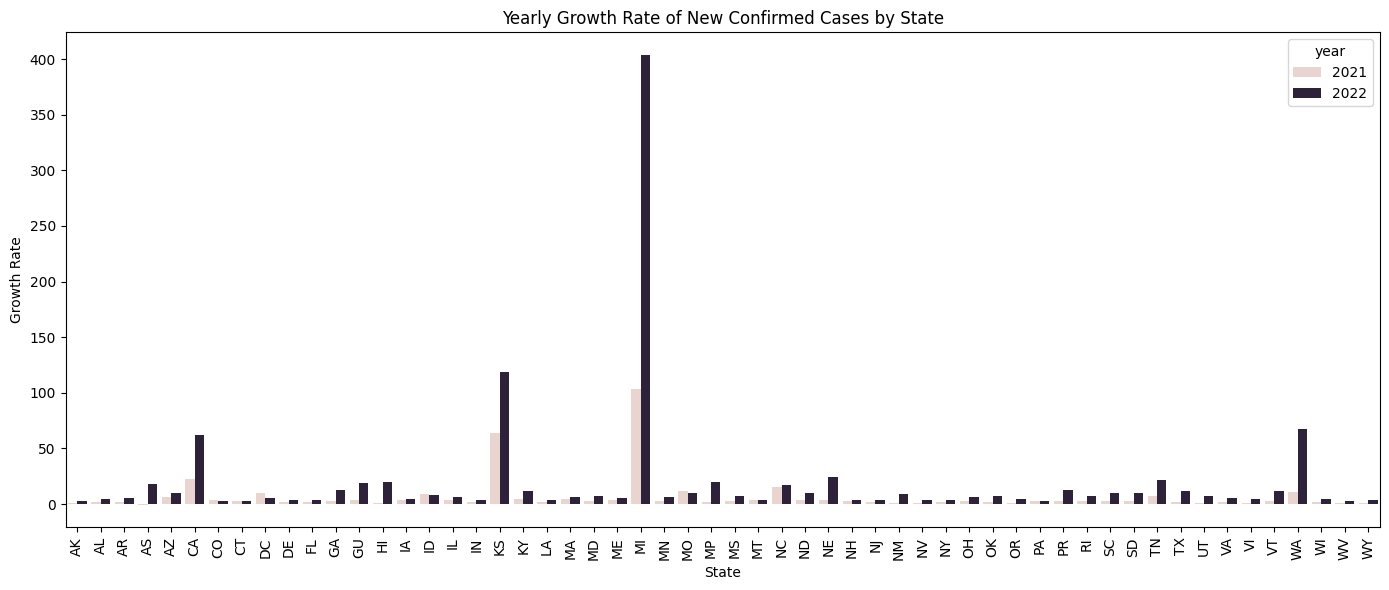

In [ ]:
# Yearly Growth Rate Analysis
pandas_df['yearly_growth_rate'] = pandas_df.groupby('state')['new_confirmed'].pct_change().fillna(0)
growth_rate_df = pandas_df.groupby(['state', 'year']).agg({'yearly_growth_rate': 'mean'}).reset_index()
plt.figure(figsize=(14, 6))
sns.barplot(data=growth_rate_df, x='state', y='yearly_growth_rate', hue='year')
plt.title('Yearly Growth Rate of New Confirmed Cases by State')
plt.xlabel('State')
plt.ylabel('Growth Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, DoubleType, DateType

# Step 1: Handle Missing Values
# Fill null values in numeric columns with 0
numeric_cols = [
    "new_confirmed", "new_deceased", "cumulative_vaccine_doses_administered_pfizer",
    "cumulative_vaccine_doses_administered_moderna", "cumulative_vaccine_doses_administered_janssen",
    "new_vaccine_doses_administered_pfizer", "new_vaccine_doses_administered_moderna", "new_vaccine_doses_administered_janssen"
]
spark_df = spark_df.fillna(0, subset=numeric_cols)

# Step 2: Data Type Conversion
# Convert 'date' column to DateType
spark_df = spark_df.withColumn("date", F.to_date(F.col("date"), "yyyy-MM-dd"))

# Convert numeric columns to appropriate data types
for col_name in numeric_cols:
    spark_df = spark_df.withColumn(col_name, F.col(col_name).cast(IntegerType()))

# Step 3: Feature Engineering
# Extract year and month from the date column
spark_df = spark_df.withColumn("year", F.year(F.col("date")))
spark_df = spark_df.withColumn("month", F.month(F.col("date")))

# Step 4: Outlier Detection and Treatment
# Here, we will simply filter out rows with negative values in critical columns
spark_df = spark_df.filter(
    (F.col("new_confirmed") >= 0) &
    (F.col("new_deceased") >= 0) &
    (F.col("new_vaccine_doses_administered_pfizer") >= 0) &
    (F.col("new_vaccine_doses_administered_moderna") >= 0) &
    (F.col("new_vaccine_doses_administered_janssen") >= 0)
)

# Step 5: Remove Duplicates
# Drop duplicate rows based on 'date', 'location_key', and 'country_code'
spark_df = spark_df.dropDuplicates(["date", "location_key", "country_code"])

# Step 6: Data Aggregation (Optional)
# Example: Aggregate data by month and location_key
monthly_df = spark_df.groupBy("location_key", "year", "month").agg(
    F.sum("new_confirmed").alias("monthly_new_confirmed"),
    F.sum("new_deceased").alias("monthly_new_deceased"),
    F.sum("new_vaccine_doses_administered_pfizer").alias("monthly_pfizer_doses"),
    F.sum("new_vaccine_doses_administered_moderna").alias("monthly_moderna_doses"),
    F.sum("new_vaccine_doses_administered_janssen").alias("monthly_janssen_doses")
)

# Step 7: Show the pre-processed data
spark_df.show()
monthly_df.show()


+----------+------------+------------+-------------+------------+--------------------------------------------+---------------------------------------------+---------------------------------------------+-------------------------------------+--------------------------------------+--------------------------------------+----+-----+-----+
|      date|location_key|country_code|new_confirmed|new_deceased|cumulative_vaccine_doses_administered_pfizer|cumulative_vaccine_doses_administered_moderna|cumulative_vaccine_doses_administered_janssen|new_vaccine_doses_administered_pfizer|new_vaccine_doses_administered_moderna|new_vaccine_doses_administered_janssen|year|month|state|
+----------+------------+------------+-------------+------------+--------------------------------------------+---------------------------------------------+---------------------------------------------+-------------------------------------+--------------------------------------+--------------------------------------+----+-----

In [ ]:
# Calculate descriptive statistics for the numerical columns in the dataset
numeric_summary = spark_df.select(numeric_cols).describe()
numeric_summary.show()


+-------+-------------+------------+--------------------------------------------+---------------------------------------------+---------------------------------------------+-------------------------------------+--------------------------------------+--------------------------------------+
|summary|new_confirmed|new_deceased|cumulative_vaccine_doses_administered_pfizer|cumulative_vaccine_doses_administered_moderna|cumulative_vaccine_doses_administered_janssen|new_vaccine_doses_administered_pfizer|new_vaccine_doses_administered_moderna|new_vaccine_doses_administered_janssen|
+-------+-------------+------------+--------------------------------------------+---------------------------------------------+---------------------------------------------+-------------------------------------+--------------------------------------+--------------------------------------+
|  count|      1000000|     1000000|                                     1000000|                                      1000000|   

In [ ]:
# Import necessary libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, GBTRegressor, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import patches

# Calculate total vaccinations administered
spark_df = spark_df.withColumn("total_vaccinations",
    col("cumulative_vaccine_doses_administered_pfizer") +
    col("cumulative_vaccine_doses_administered_moderna") +
    col("cumulative_vaccine_doses_administered_janssen")
)

# Selecting features and label for mortality prediction using Vector Linear Regression
feature_columns_mortality = [
    "new_confirmed",
    "cumulative_vaccine_doses_administered_pfizer",
    "cumulative_vaccine_doses_administered_moderna",
    "cumulative_vaccine_doses_administered_janssen",
    "total_vaccinations",
    "new_vaccine_doses_administered_pfizer",
    "new_vaccine_doses_administered_moderna",
    "new_vaccine_doses_administered_janssen"
]

# Assemble features into a feature vector
assembler_mortality = VectorAssembler(inputCols=feature_columns_mortality, outputCol="features")
mortality_df = assembler_mortality.transform(spark_df).select("features", col("new_deceased").alias("label"))

# Split the data into training and testing sets
train_data_mortality, test_data_mortality = mortality_df.randomSplit([0.8, 0.2], seed=42)

# Initialize Vector Linear Regression model for mortality prediction
vlr_mortality = LinearRegression(featuresCol="features", labelCol="label", maxIter=100, regParam=0.05, elasticNetParam=0.5)

# Train the Vector Linear Regression model
vlr_model_mortality = vlr_mortality.fit(train_data_mortality)

# Make predictions on the test data
predictions_mortality_vlr = vlr_model_mortality.transform(test_data_mortality).withColumnRenamed("prediction", "VectorLinearRegression")

# Evaluate the Vector Linear Regression model
eval_summary_vlr = vlr_model_mortality.evaluate(test_data_mortality)
print(f"Vector Linear Regression - RMSE: {eval_summary_vlr.rootMeanSquaredError}")
print(f"Vector Linear Regression - R2: {eval_summary_vlr.r2}")

Vector Linear Regression - RMSE: 96.35017269719047
Vector Linear Regression - R2: 0.6192366509042494


In [ ]:
# Initialize Gradient Boosted Tree Regressor for mortality prediction
gbt_mortality = GBTRegressor(featuresCol="features", labelCol="label", maxIter=50, maxDepth=5, seed=42)

# Train the Gradient Boosted Tree model
gbt_model_mortality = gbt_mortality.fit(train_data_mortality)

# Make predictions on the test data
predictions_mortality_gbt = gbt_model_mortality.transform(test_data_mortality).withColumnRenamed("prediction", "GBT")

# Evaluate the Gradient Boosted Tree model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="GBT", metricName="rmse")
rmse_gbt = evaluator.evaluate(predictions_mortality_gbt)
print(f"Gradient Boosted Trees - RMSE: {rmse_gbt}")

r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="GBT", metricName="r2")
r2_gbt = r2_evaluator.evaluate(predictions_mortality_gbt)
print(f"Gradient Boosted Trees - R2: {r2_gbt}")


Gradient Boosted Trees - RMSE: 103.21946063963527
Gradient Boosted Trees - R2: 0.5630081734492582


In [ ]:
# Initialize Random Forest Regressor model for mortality prediction
rf_mortality = RandomForestRegressor(featuresCol="features", labelCol="label", numTrees=100, maxDepth=10, seed=42)

# Train the Random Forest model
rf_model_mortality = rf_mortality.fit(train_data_mortality)

# Make predictions on the test data
predictions_mortality_rf = rf_model_mortality.transform(test_data_mortality).withColumnRenamed("prediction", "RandomForest")

# Evaluate the Random Forest model
evaluator = RegressionEvaluator(labelCol="label", predictionCol="RandomForest", metricName="rmse")
rmse_rf = evaluator.evaluate(predictions_mortality_rf)
print(f"Random Forest - RMSE: {rmse_rf}")

r2_evaluator = RegressionEvaluator(labelCol="label", predictionCol="RandomForest", metricName="r2")
r2_rf = r2_evaluator.evaluate(predictions_mortality_rf)
print(f"Random Forest - R2: {r2_rf}")


Random Forest - RMSE: 103.69481754896375
Random Forest - R2: 0.5589739456809637


<ipython-input-58-da338b414d94>:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


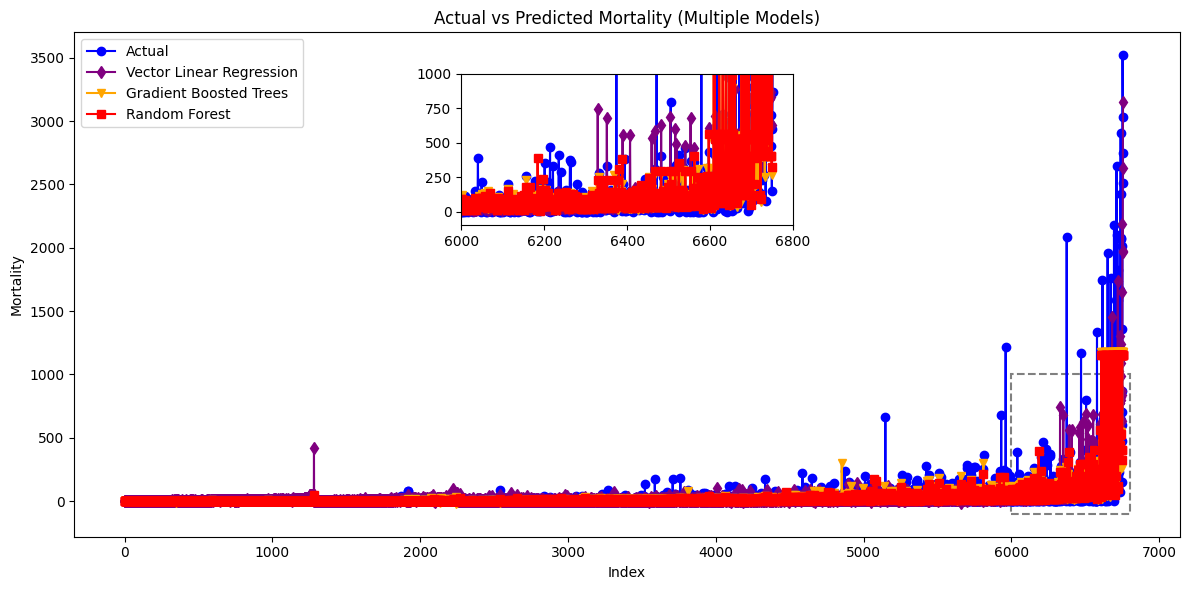

In [ ]:
# Combine all predictions into a single DataFrame
from pyspark.sql import DataFrame

def combine_predictions(*dfs: DataFrame) -> DataFrame:
    result_df = dfs[0]
    for df in dfs[1:]:
        result_df = result_df.join(df.select("features", "label", df.columns[-1]), on=["features", "label"])
    return result_df

combined_predictions = combine_predictions(predictions_mortality_vlr, predictions_mortality_gbt, predictions_mortality_rf)

# Convert combined predictions to Pandas DataFrame for plotting
predictions_pd = combined_predictions.toPandas()

# Plotting Actual vs Predicted values for better visualization
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(predictions_pd.index, predictions_pd['label'], label='Actual', color='blue', linestyle='-', marker='o')
ax.plot(predictions_pd.index, predictions_pd['VectorLinearRegression'], label='Vector Linear Regression', color='purple', linestyle='-', marker='d')
ax.plot(predictions_pd.index, predictions_pd['GBT'], label='Gradient Boosted Trees', color='orange', linestyle='-', marker='v')
ax.plot(predictions_pd.index, predictions_pd['RandomForest'], label='Random Forest', color='red', linestyle='-', marker='s')
ax.set_xlabel('Index')
ax.set_ylabel('Mortality')
ax.set_title('Actual vs Predicted Mortality (Multiple Models)')
ax.legend()

# Adding an inset axis manually placed for a magnified view in the top right corner
axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)

# Specify the range for the inset (e.g., zoom in on a small part of the graph)
x1, x2 = 6000, 6800  # Choose a narrow x-axis range for zoomed-in detail
y1, y2 = -100, 1000
#y1, y2 = predictions_pd['label'][x1:x2].min(), predictions_pd['label'][x1:x2].max()  # Adjust y-axis range based on data

# Plot the same data in the inset
axins.plot(predictions_pd.index, predictions_pd['label'], color='blue', linestyle='-', marker='o')
axins.plot(predictions_pd.index, predictions_pd['VectorLinearRegression'], color='purple', linestyle='-', marker='d')
axins.plot(predictions_pd.index, predictions_pd['GBT'], color='orange', linestyle='-', marker='v')
axins.plot(predictions_pd.index, predictions_pd['RandomForest'], color='red', linestyle='-', marker='s')

# Set the limits for the inset view to zoom in
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Add a rectangle to the main plot to indicate the zoomed-in area
rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='gray', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(rectangle)

plt.tight_layout()
plt.show()


+---------+-----+--------------------+
| features|label|          prediction|
+---------+-----+--------------------+
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
|(3,[],[])|  0.0|0.053014403187547576|
+---------+-----+--------------------+
only showing top 20 rows

Vaccine Rollout Efficiency Prediction 

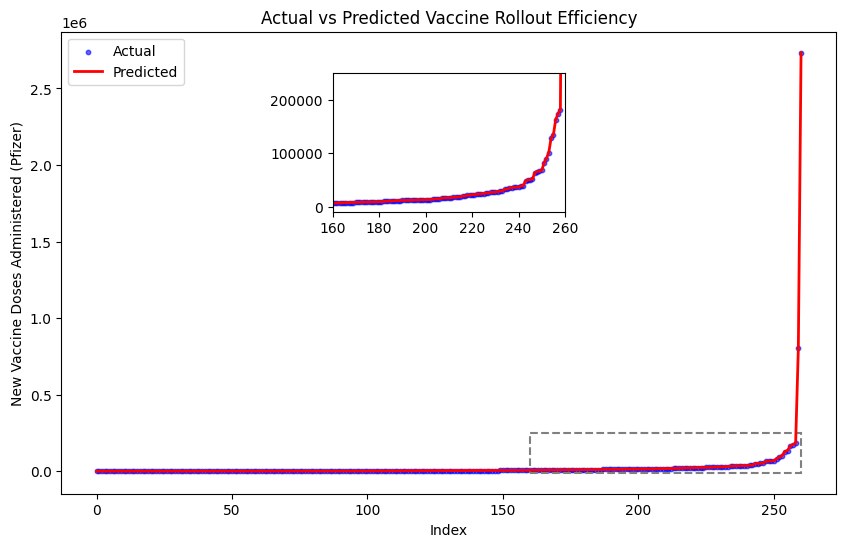

In [ ]:
# Prediction of Vaccine Rollout Efficiency
# Selecting features and label for prediction
feature_columns_vaccine = [ "new_vaccine_doses_administered_pfizer",
    "new_vaccine_doses_administered_moderna",
    "new_vaccine_doses_administered_janssen"
]

# Remove rows with NaN values in feature columns
cleaned_df = spark_df.na.drop(subset=feature_columns_vaccine)

assembler_vaccine = VectorAssembler(inputCols=feature_columns_vaccine, outputCol="features")
vaccine_df = assembler_vaccine.transform(cleaned_df).select("features", col("new_vaccine_doses_administered_pfizer").alias("label"))

# Split the data into training and testing sets
train_data_vaccine, test_data_vaccine = vaccine_df.randomSplit([0.8, 0.2], seed=42)

# Initialize Linear Regression model for vaccine rollout efficiency prediction with regularization
lr_vaccine = LinearRegression(featuresCol="features", labelCol="label", regParam=0.1)

# Train the model
lr_model_vaccine = lr_vaccine.fit(train_data_vaccine)

# Make predictions on the test data
predictions_vaccine = lr_model_vaccine.transform(test_data_vaccine)

# Show predictions
predictions_vaccine.select("features", "label", col("prediction")).show()

# Evaluate the model
eval_summary_vaccine = lr_model_vaccine.evaluate(test_data_vaccine)
print(f"Vaccine Rollout Efficiency Prediction - RMSE: {eval_summary_vaccine.rootMeanSquaredError}")
print(f"Vaccine Rollout Efficiency Prediction - R2: {eval_summary_vaccine.r2}")

# Import necessary modules
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import patches

# Plotting the actual vs predicted vaccine rollout efficiency
predictions_vaccine_pd = predictions_vaccine.select("label", "prediction").toPandas()
predictions_vaccine_pd = predictions_vaccine_pd.sort_values(by="label").reset_index(drop=True)

# Define the main plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(predictions_vaccine_pd.index, predictions_vaccine_pd['label'], label='Actual', color='blue', s=10, alpha=0.6)
ax.plot(predictions_vaccine_pd.index, predictions_vaccine_pd['prediction'], label='Predicted', color='red', linewidth=2)
ax.set_xlabel('Index')
ax.set_ylabel('New Vaccine Doses Administered (Pfizer)')
ax.set_title('Actual vs Predicted Vaccine Rollout Efficiency')
ax.legend()

# Adding an inset axis manually placed for a magnified view in the top left corner
axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)

# Specify the range for the inset (e.g., zoom in on a small part of the graph)
x1, x2 = 160, 260  # Choose a narrow x-axis range for zoomed-in detail
y1, y2 = -10000, 250000  # Adjust y-axis range as necessary for better zoom

# Plot the same data in the inset
axins.scatter(predictions_vaccine_pd.index, predictions_vaccine_pd['label'], color='blue', s=10, alpha=0.6)
axins.plot(predictions_vaccine_pd.index, predictions_vaccine_pd['prediction'], color='red', linewidth=2)

# Set the limits for the inset view to zoom in
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Add a rectangle to the main plot to indicate the zoomed-in area
rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='gray', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(rectangle)

plt.show()



+---------+-----+-------------------+
| features|label|         prediction|
+---------+-----+-------------------+
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
|(2,[],[])|  0.0|0.05302084138808244|
+---------+-----+-------------------+
only showing top 20 rows

Vaccine Rollout Efficiency Prediction - RMSE: 0.58855006482969

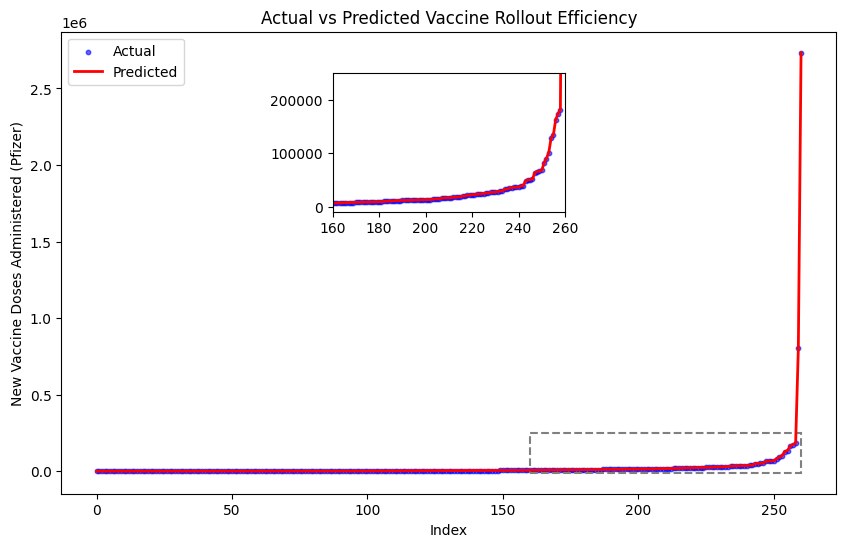

In [ ]:
# Prediction of Vaccine Rollout Efficiency
# Selecting features and label for prediction
feature_columns_vaccine = [ "new_vaccine_doses_administered_pfizer",
    "new_vaccine_doses_administered_moderna"
]

# Remove rows with NaN values in feature columns
cleaned_df = spark_df.na.drop(subset=feature_columns_vaccine)

assembler_vaccine = VectorAssembler(inputCols=feature_columns_vaccine, outputCol="features")
vaccine_df = assembler_vaccine.transform(cleaned_df).select("features", col("new_vaccine_doses_administered_pfizer").alias("label"))

# Split the data into training and testing sets
train_data_vaccine, test_data_vaccine = vaccine_df.randomSplit([0.8, 0.2], seed=42)

# Initialize Linear Regression model for vaccine rollout efficiency prediction with regularization
lr_vaccine = LinearRegression(featuresCol="features", labelCol="label", regParam=0.1)

# Train the model
lr_model_vaccine = lr_vaccine.fit(train_data_vaccine)

# Make predictions on the test data
predictions_vaccine = lr_model_vaccine.transform(test_data_vaccine)

# Show predictions
predictions_vaccine.select("features", "label", col("prediction")).show()

# Evaluate the model
eval_summary_vaccine = lr_model_vaccine.evaluate(test_data_vaccine)
print(f"Vaccine Rollout Efficiency Prediction - RMSE: {eval_summary_vaccine.rootMeanSquaredError}")
print(f"Vaccine Rollout Efficiency Prediction - R2: {eval_summary_vaccine.r2}")

# Import necessary modules
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import patches

# Plotting the actual vs predicted vaccine rollout efficiency
predictions_vaccine_pd = predictions_vaccine.select("label", "prediction").toPandas()
predictions_vaccine_pd = predictions_vaccine_pd.sort_values(by="label").reset_index(drop=True)

# Define the main plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(predictions_vaccine_pd.index, predictions_vaccine_pd['label'], label='Actual', color='blue', s=10, alpha=0.6)
ax.plot(predictions_vaccine_pd.index, predictions_vaccine_pd['prediction'], label='Predicted', color='red', linewidth=2)
ax.set_xlabel('Index')
ax.set_ylabel('New Vaccine Doses Administered (Pfizer)')
ax.set_title('Actual vs Predicted Vaccine Rollout Efficiency')
ax.legend()

# Adding an inset axis manually placed for a magnified view in the top left corner
axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)

# Specify the range for the inset (e.g., zoom in on a small part of the graph)
x1, x2 = 160, 260  # Choose a narrow x-axis range for zoomed-in detail
y1, y2 = -10000, 250000   # Adjust y-axis range as necessary for better zoom

# Plot the same data in the inset
axins.scatter(predictions_vaccine_pd.index, predictions_vaccine_pd['label'], color='blue', s=10, alpha=0.6)
axins.plot(predictions_vaccine_pd.index, predictions_vaccine_pd['prediction'], color='red', linewidth=2)

# Set the limits for the inset view to zoom in
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Add a rectangle to the main plot to indicate the zoomed-in area
rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='gray', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(rectangle)

plt.show()



+---------+-----+-----------------+
| features|label|       prediction|
+---------+-----+-----------------+
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
|(2,[],[])|  0.0|3257.197447954761|
+---------+-----+-----------------+
only showing top 20 rows

Vaccine Rollout Efficiency Prediction - RMSE: 38983.014417113154
Vaccine Rollout Efficiency Prediction - R2: 0

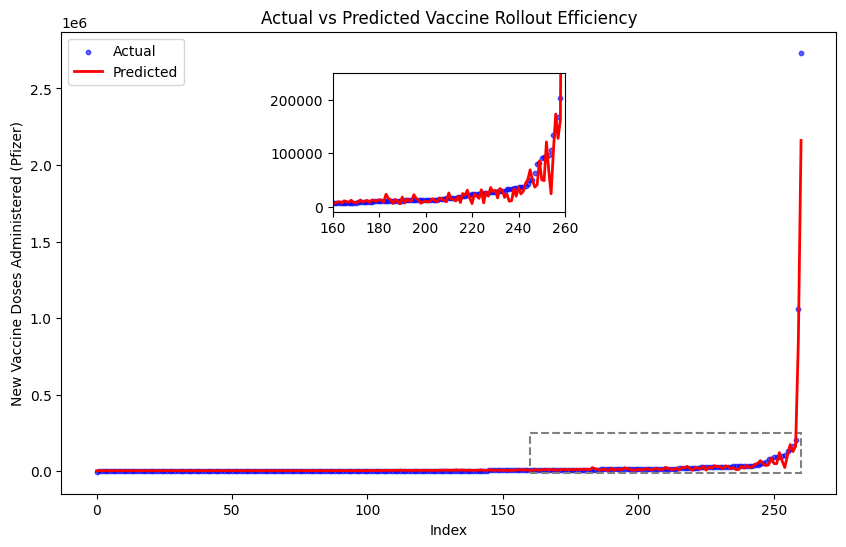

In [ ]:
# Prediction of Vaccine Rollout Efficiency
# Selecting features and label for prediction
feature_columns_vaccine = [
    "new_vaccine_doses_administered_moderna",
    "new_vaccine_doses_administered_janssen"
]

# Remove rows with NaN values in feature columns
cleaned_df = spark_df.na.drop(subset=feature_columns_vaccine)

assembler_vaccine = VectorAssembler(inputCols=feature_columns_vaccine, outputCol="features")
vaccine_df = assembler_vaccine.transform(cleaned_df).select("features", col("new_vaccine_doses_administered_pfizer").alias("label"))

# Split the data into training and testing sets
train_data_vaccine, test_data_vaccine = vaccine_df.randomSplit([0.8, 0.2], seed=42)

# Initialize Linear Regression model for vaccine rollout efficiency prediction with regularization
lr_vaccine = LinearRegression(featuresCol="features", labelCol="label", regParam=0.1)

# Train the model
lr_model_vaccine = lr_vaccine.fit(train_data_vaccine)

# Make predictions on the test data
predictions_vaccine = lr_model_vaccine.transform(test_data_vaccine)

# Show predictions
predictions_vaccine.select("features", "label", col("prediction")).show()

# Evaluate the model
eval_summary_vaccine = lr_model_vaccine.evaluate(test_data_vaccine)
print(f"Vaccine Rollout Efficiency Prediction - RMSE: {eval_summary_vaccine.rootMeanSquaredError}")
print(f"Vaccine Rollout Efficiency Prediction - R2: {eval_summary_vaccine.r2}")

# Import necessary modules
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib import patches

# Plotting the actual vs predicted vaccine rollout efficiency
predictions_vaccine_pd = predictions_vaccine.select("label", "prediction").toPandas()
predictions_vaccine_pd = predictions_vaccine_pd.sort_values(by="label").reset_index(drop=True)

# Define the main plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(predictions_vaccine_pd.index, predictions_vaccine_pd['label'], label='Actual', color='blue', s=10, alpha=0.6)
ax.plot(predictions_vaccine_pd.index, predictions_vaccine_pd['prediction'], label='Predicted', color='red', linewidth=2)
ax.set_xlabel('Index')
ax.set_ylabel('New Vaccine Doses Administered (Pfizer)')
ax.set_title('Actual vs Predicted Vaccine Rollout Efficiency')
ax.legend()

# Adding an inset axis manually placed for a magnified view in the top left corner
axins = inset_axes(ax, width="30%", height="30%", loc='upper center', borderpad=3)

# Specify the range for the inset (e.g., zoom in on a small part of the graph)
x1, x2 = 160, 260  # Choose a narrow x-axis range for zoomed-in detail
y1, y2 = -10000, 250000   # Adjust y-axis range as necessary for better zoom

# Plot the same data in the inset
axins.scatter(predictions_vaccine_pd.index, predictions_vaccine_pd['label'], color='blue', s=10, alpha=0.6)
axins.plot(predictions_vaccine_pd.index, predictions_vaccine_pd['prediction'], color='red', linewidth=2)

# Set the limits for the inset view to zoom in
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)

# Add a rectangle to the main plot to indicate the zoomed-in area
rectangle = patches.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='gray', facecolor='none', linestyle='--', linewidth=1.5)
ax.add_patch(rectangle)

plt.show()

